In [2]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("../McKinsey Analytics Contest"))
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from scipy.stats import norm, skew 
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
train = pd.read_csv('../McKinsey Analytics Contest/train_ZoGVYWq.csv')
test = pd.read_csv('../McKinsey Analytics Contest/test_66516Ee.csv')

['.ipynb_checkpoints', '383_500839_cf_final_hDoNzcR.ipynb', '383_524013_cf_mckinsey_ckF6BWV.ipynb', 'McKinsey Analytics Contest.ipynb', 'sample_submission_sLex1ul.csv', 'submission.csv', 'test_66516Ee.csv', 'train_ZoGVYWq.csv']


In [3]:
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['id']
test_ID = test['id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("id", axis = 1, inplace = True)
test.drop("id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (79853, 13) 
The test data size before dropping Id feature is : (34224, 12) 

The train data size after dropping Id feature is : (79853, 12) 
The test data size after dropping Id feature is : (34224, 11) 


In [5]:
df = train.groupby(['premium', 'renewal']).Income.count()

In [6]:
df2 = df.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()
df2.head()

,premium,renewal,Income
0,1200,0,0.072
1,1200,1,0.928
2,3300,0,0.073
3,3300,1,0.927
4,5400,0,0.076


In [7]:
df3 = df2.loc[df2['renewal'] ==1]
df3.head()

,premium,renewal,Income
1,1200,1,0.928
3,3300,1,0.927
5,5400,1,0.924
7,5700,1,0.916
9,7500,1,0.933


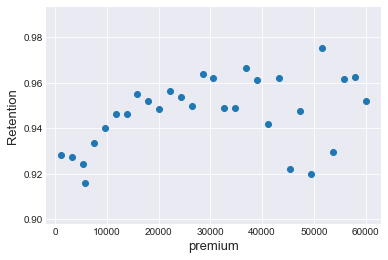

In [8]:
fig, ax = plt.subplots()
ax.scatter(x = df3['premium'], y = df3['Income'])
plt.ylabel('Retention', fontsize=13)
plt.xlabel('premium', fontsize=13)
plt.show()

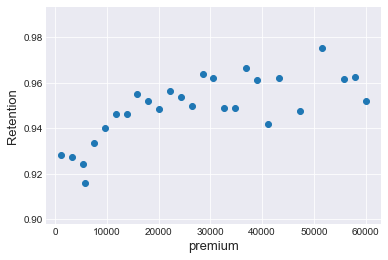

In [9]:
df3 = df3.drop(df3[(df3['premium']>40000) & (df3['Income']<0.94)].index)

fig, ax = plt.subplots()
ax.scatter(x = df3['premium'], y = df3['Income'])
plt.ylabel('Retention', fontsize=13)
plt.xlabel('premium', fontsize=13)
plt.show()

In [10]:
train['perc_renewal'] = df2['Income']


 mu = 0.95 and sigma = 0.01



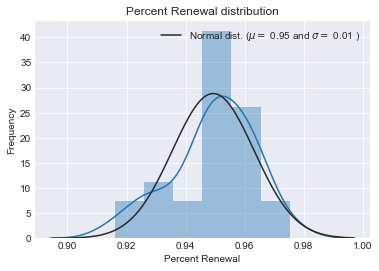

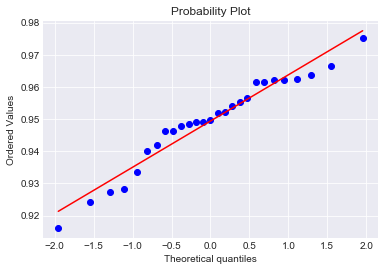

In [11]:
sns.distplot(df3['Income'] , fit=norm);

(mu, sigma) = norm.fit(df3['Income'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.xlabel('Percent Renewal')
plt.title('Percent Renewal distribution')

fig = plt.figure()
res = stats.probplot(df3['Income'], plot=plt)
plt.show()

In [12]:
train['renewal'] = train['renewal'].apply(str)

In [13]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.renewal.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['perc_renewal', 'renewal'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (114077, 11)


In [14]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
application_underwriting_score,3.767
Count_more_than_12_months_late,0.112
Count_6-12_months_late,0.112
Count_3-6_months_late,0.112


Text(0.5,1,'Percent missing data by feature')

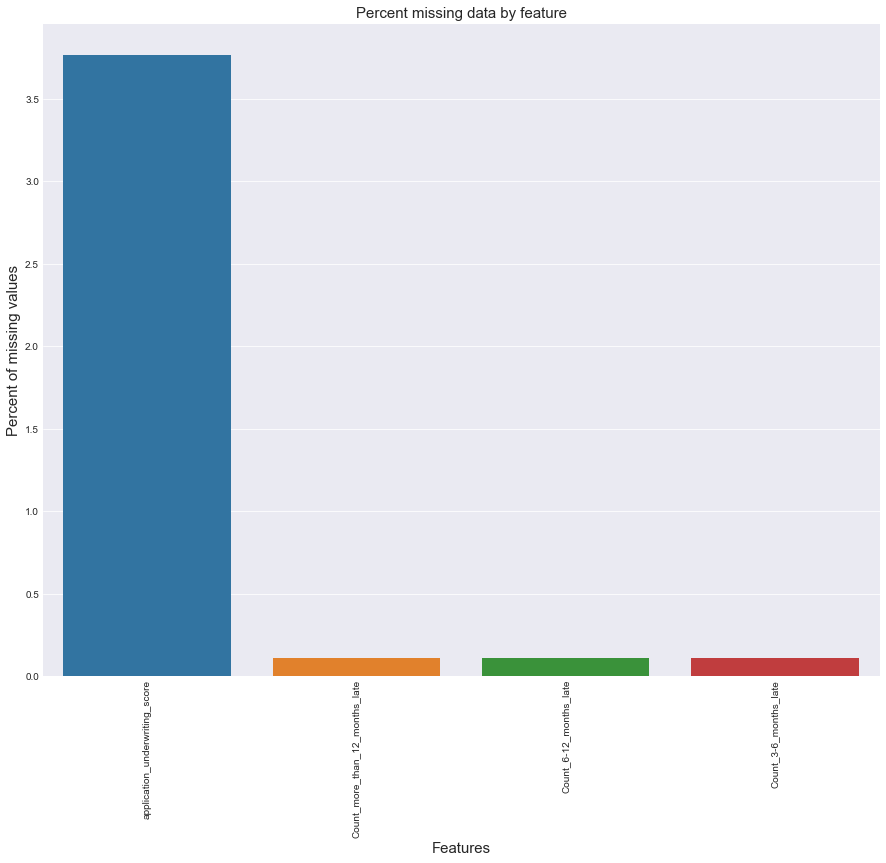

In [15]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

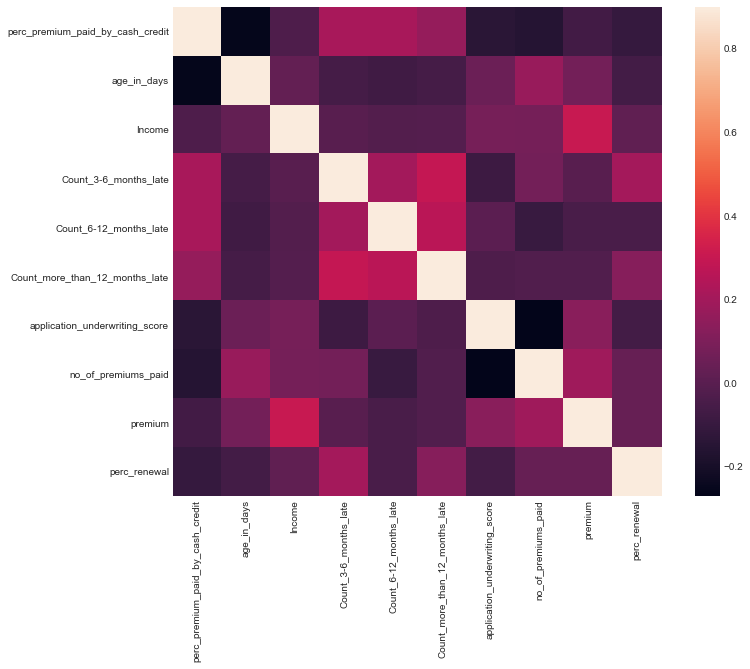

In [16]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [17]:
all_data['application_underwriting_score'] = all_data['application_underwriting_score'].fillna(all_data['application_underwriting_score'].mean())

In [18]:
for col in ('Count_more_than_12_months_late', 'Count_6-12_months_late', 'Count_3-6_months_late'):
    all_data[col] = all_data[col].fillna(0)

In [19]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [20]:
from sklearn.preprocessing import LabelEncoder
cols = ('sourcing_channel', 'residence_area_type')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (114077, 11)


In [21]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
Income,112.559
Count_6-12_months_late,10.019
Count_more_than_12_months_late,7.838
Count_3-6_months_late,4.249
premium,2.192
no_of_premiums_paid,1.225
sourcing_channel,1.006
perc_premium_paid_by_cash_credit,0.892
age_in_days,0.228
residence_area_type,-0.421


In [22]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 11 skewed numerical features to Box Cox transform


In [23]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(114077, 11)


In [24]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [25]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [26]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [27]:
n_folds = 3

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [28]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [29]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [30]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [31]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [32]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [33]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [34]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.2217 (0.0017)



In [35]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.2217 (0.0017)



In [36]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.2502 (0.0028)



In [37]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [38]:
averaged_models = AveragingModels(models = (ENet, GBoost, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.2253 (0.0022)



In [39]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [40]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.2217 (0.0017)


In [41]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [42]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.22163581270191868


In [43]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.20869202136372095


In [44]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.21828848527655959


In [45]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.10 +
               xgb_train_pred*0.80 + lgb_train_pred*0.10 ))

RMSLE score on train data:
0.21034292173560204


In [46]:
ensemble = stacked_pred*0.12 + xgb_pred*0.66 + lgb_pred*0.22

In [61]:
sub = pd.DataFrame()
sub['id'] = test_ID
sub['renewal'] = ensemble
def conditions(frame):
    for i in frame:
        if (i - 1 > 0) & (i -1 < 1):
            val = i - 1
        elif i - 1 < 1:
            val = 0
        else:
            val = 1
    return val

In [62]:
sub['renewal'] = sub.apply(conditions, axis = 1)
def incentives(row):
    x = np.log(1-((1-row['renewal'])/20)) * -5
    return np.log(1-(x/10)) * -400

In [63]:
sub['incentives'] = sub.apply(incentives, axis = 1)
sub.to_csv('submission2.csv',index=False)

In [ ]:
sub.loc[sub['renewal'] > 1]

In [ ]:
sub.loc[sub['renewal'] < 0]

In [ ]:
sub.loc[sub['renewal'] == 1]

In [ ]:
sub.loc[sub['renewal'] == 0]